In [1]:
import sys, pathlib
sys.path.append(str(pathlib.Path.cwd().parent))
# sys.path

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tabulate import tabulate

In [3]:
%load_ext autoreload
%autoreload 2
%aimport optiml.queries
%matplotlib inline

In [4]:
from optiml.connection import SnowflakeConnConfig
from optiml.queries import SNFLKQuery
connection = SnowflakeConnConfig(accountname='VUJSGPR-XG91870', warehousename="XSMALL_WH").create_connection()
qlib = SNFLKQuery(connection, 'KIV')

/Users/skumar/.snowsql/config
Connecting...


In [17]:
df = qlib.total_cost_breakdown('2022-10-01', '2022-10-31')
df = qlib.cost_by_wh('2022-10-01', '2022-10-31')
df

,WAREHOUSE_NAME,CREDITS_USED_COMPUTE_SUM,TOTAL_DOLLARS_USED
0,PROD_WH,612.847780833,1225.695561666
1,ML_WH,70.201448074,140.402896148
2,DEV_WH,398.834608888,797.669217776
3,DAILY_REFRESH_WH,173.591642219,347.183284438
4,CLOUD_SERVICES_ONLY,0.000201944,0.000403888


In [19]:
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{"type": "pie"}, {"type": "table"}]]
)
# fig = go.Figure()
fig.add_trace(go.Pie(labels=df['WAREHOUSE_NAME'].tolist(), values=df['CREDITS_USED_COMPUTE_SUM'].tolist()),row=1, col=1)
fig.add_trace(go.Table(header=dict(values=['A Scores', 'B Scores']),
                 cells=dict(values=[[100, 90, 80, 90], [95, 85, 75, 95]])),row=1, col=2)
fig.show()
# display(tabulate(df, headers = 'keys', tablefmt = 'html', showindex="never"))
# fig = px.pie(df, values='CREDITS_USED_COMPUTE_SUM', names='WAREHOUSE_NAME', title='Credits Used by Type')

In [13]:
df.to_dict()

{'WAREHOUSE_NAME': {0: 'PROD_WH',
  1: 'ML_WH',
  2: 'DEV_WH',
  3: 'DAILY_REFRESH_WH',
  4: 'CLOUD_SERVICES_ONLY'},
 'CREDITS_USED_COMPUTE_SUM': {0: Decimal('612.847780833'),
  1: Decimal('70.201448074'),
  2: Decimal('398.834608888'),
  3: Decimal('173.591642219'),
  4: Decimal('0.000201944')},
 'TOTAL_DOLLARS_USED': {0: Decimal('1225.695561666'),
  1: Decimal('140.402896148'),
  2: Decimal('797.669217776'),
  3: Decimal('347.183284438'),
  4: Decimal('0.000403888')}}

In [13]:

display(tabulate(df, headers = 'keys', tablefmt = 'html', showindex="never"))
fig = px.pie(df, values='CREDITS_USED_COMPUTE_SUM', names='WAREHOUSE_NAME', title='Credits Used by Type')

,WAREHOUSE_NAME,CREDITS_USED_COMPUTE_SUM,TOTAL_DOLLARS_USED
0,PROD_WH,612.847780833,1225.695561666
1,ML_WH,70.201448074,140.402896148
2,DEV_WH,398.834608888,797.669217776
3,DAILY_REFRESH_WH,173.591642219,347.183284438
4,CLOUD_SERVICES_ONLY,0.000201944,0.000403888


In [14]:
df = qlib.cost_of_compute('2022-10-01', '2022-10-31')
df

,WAREHOUSE_NAME,TOTAL_CREDITS_USED,TOTAL_DOLLARS_USED
0,CLOUD_SERVICES_ONLY,0E-9,0E-9
1,DAILY_REFRESH_WH,171.866111109,343.732222218
2,DEV_WH,390.860833332,781.721666664
3,ML_WH,69.656666677,139.313333354
4,PROD_WH,576.646111111,1153.292222222


In [7]:
df['TOTAL_CREDITS_USED'] = df['TOTAL_CREDITS_USED'].astype(float)
df['TOTAL_DOLLARS_USED'] = df['TOTAL_DOLLARS_USED'].astype(float)
df.dtypes

WAREHOUSE_GROUP_NAME     object
TOTAL_CREDITS_USED      float64
TOTAL_DOLLARS_USED      float64
dtype: object

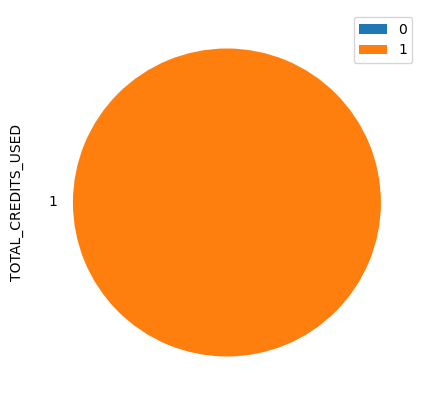

In [8]:
df.plot.pie(y='TOTAL_CREDITS_USED', figsize=(5, 5))
fig = px.pie(df, values='TOTAL_DOLLARS_USED', names='WAREHOUSE_GROUP_NAME', title='Credits Used by Type')

* Largely used by compute
* In 2020 auto clustering was on but was turned off - why?
* Storage credits at 0 since storage is charged as a flat rate - are numbers consistent?
* Definitely did not use $80K worth of credits in October since total bill is $50K - so something is wrong!


In [12]:
df = qlib.cost_of_compute_ts('2022-10-12', '2022-10-13')

In [13]:
df

,WAREHOUSE_GROUP_NAME,TOTAL_CREDITS_USED,CUMULATIVE_CREDITS_TOTAL,START_TIME,END_TIME
0,WH Compute,10.491666666,10.491666666,2022-10-12 00:00:00-07:00,2022-10-12 01:00:00-07:00
1,WH Compute,10.686666666,21.178333332,2022-10-12 01:00:00-07:00,2022-10-12 02:00:00-07:00
2,WH Compute,9.407499999,30.585833331,2022-10-12 02:00:00-07:00,2022-10-12 03:00:00-07:00
3,WH Compute,10.334166666,40.919999997,2022-10-12 03:00:00-07:00,2022-10-12 04:00:00-07:00
4,WH Compute,9.422499999,50.342499996,2022-10-12 04:00:00-07:00,2022-10-12 05:00:00-07:00
5,WH Compute,9.425833332,59.768333328,2022-10-12 05:00:00-07:00,2022-10-12 06:00:00-07:00
6,WH Compute,10.378333332,70.146666660,2022-10-12 06:00:00-07:00,2022-10-12 07:00:00-07:00
7,WH Compute,9.438333333,79.584999993,2022-10-12 07:00:00-07:00,2022-10-12 08:00:00-07:00
8,WH Compute,9.429999999,89.014999992,2022-10-12 08:00:00-07:00,2022-10-12 09:00:00-07:00
9,WH Compute,26.966944446,115.981944438,2022-10-12 09:00:00-07:00,2022-10-12 10:00:00-07:00


In [14]:
df['TOTAL_CREDITS_USED'].sum()

Decimal('246.493055550')